In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/earthpulse/pytorch_eo/blob/master/examples/eurosat.ipynb)

In this example we are going to train an image classifier with the [EuroSAT](https://github.com/phelber/EuroSAT) dataset. Let's start by exploring our dataset. EuroSAT comes in two flavours: RGB or MS. EuroSATRGB will use RGB images (uint8 with 3 channels) built from the MS variant, that contains all the spectral bands (uint16, 13 bands). Let's start easily loading the EuroSAT RGB version. By default, the dataset will be downloaded, processed and split in train-validation-test (80%-20%-20%). Of course, you can modify this.

In [15]:
from pytorch_eo.datasets import EuroSATRGB

ds = EuroSATRGB(batch_size=25, verbose=True) 

ds.setup()

data already extracted !
Number of images: 27000
Training samples 16200
Validation samples 5400
Test samples 5400


All out datasets have a `DataFrame` containing the required data to train the model. In this case, the list of images and labels. Use this object to explore the dataset.

In [4]:
ds.df

,image,label
0,data/2750/AnnualCrop/AnnualCrop_550.jpg,0
1,data/2750/AnnualCrop/AnnualCrop_27.jpg,0
2,data/2750/AnnualCrop/AnnualCrop_2758.jpg,0
3,data/2750/AnnualCrop/AnnualCrop_1523.jpg,0
4,data/2750/AnnualCrop/AnnualCrop_2724.jpg,0
...,...,...
26995,data/2750/SeaLake/SeaLake_2460.jpg,9
26996,data/2750/SeaLake/SeaLake_1906.jpg,9
26997,data/2750/SeaLake/SeaLake_1663.jpg,9
26998,data/2750/SeaLake/SeaLake_2334.jpg,9


The task consists on the classification of images in 10 classes.

In [5]:
ds.num_classes, ds.classes

(10,
 ['AnnualCrop',
  'Forest',
  'HerbaceousVegetation',
  'Highway',
  'Industrial',
  'Pasture',
  'PermanentCrop',
  'Residential',
  'River',
  'SeaLake'])

Let's visualize some samples from the dataset. You can extract data from the `Dataset`s objects or the `DataLoaders`. `PytorchEO` is designed to work with arbitrary number of inputs and outputs, so we use a `dict` to name the different tensors.

In [6]:
# extract the first sample of the training dataset (you can also access val_ds or test_ds for the other splits)

sample = ds.train_ds[0]

sample.keys(), sample['image'].shape, sample['label']

(dict_keys(['image', 'label']), (64, 64, 3), 7)

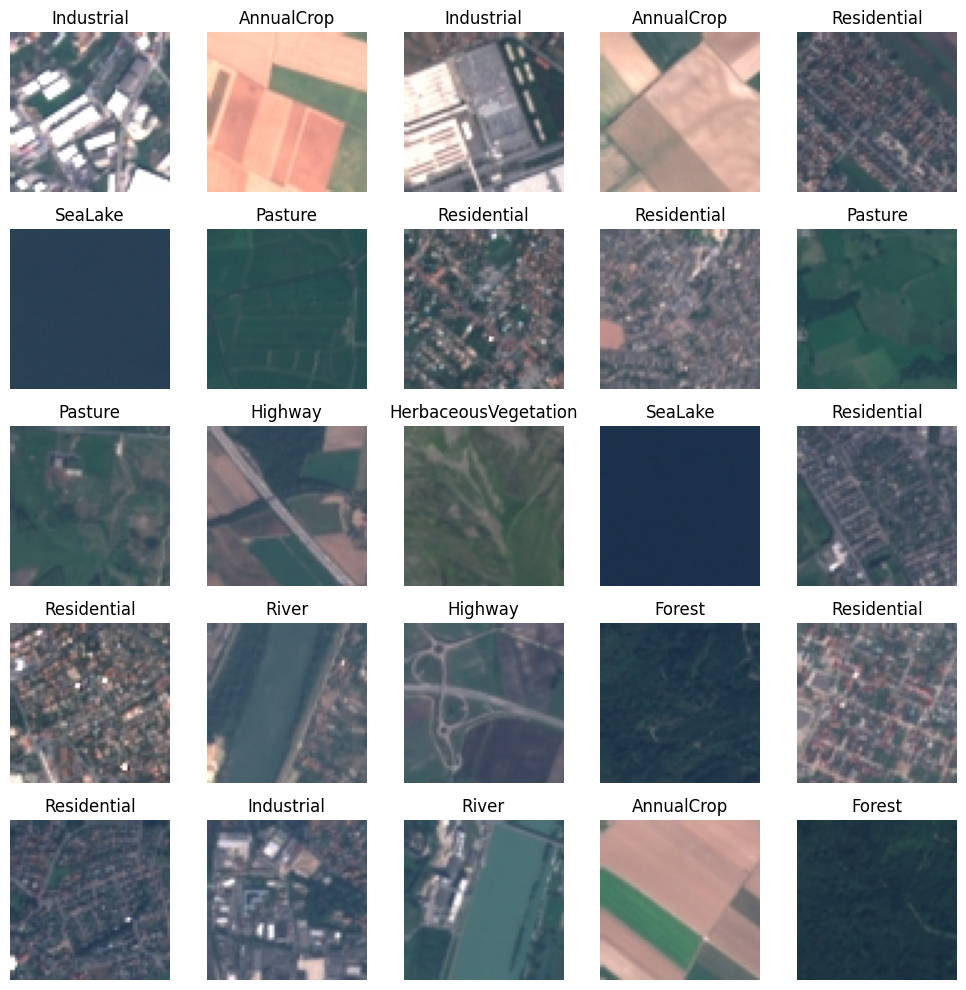

In [7]:
import matplotlib.pyplot as plt

# extract a batch of samples (you can also access val_dataloader or test_dataloader for the other splits)

batch = next(iter(ds.train_dataloader()))
imgs, labels = batch['image'], batch['label']

fig = plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = plt.subplot(5, 5, i + 1)
    ax.imshow(img)
    ax.set_title(ds.classes[label.item()])
    ax.axis('off')
plt.tight_layout()
plt.show()

Let's train an image classifier on this dataset. For that, we need a model. In this case, we are going to use a pretrained `resnet18` from the `timm` library. You can use external library or build your own models with `Pytorch`. 

In [20]:
import timm
import torch

model = timm.create_model(
	'resnet18',
	pretrained='imagenet',
	in_chans=ds.in_chans,
	num_classes=ds.num_classes
)

output = model(torch.randn(8, 3, 224, 224))
output.shape

torch.Size([8, 10])

Once the `model` is defined, we need to define a `task`. In this case, we use the `ImageClassification` task.

In [21]:
from pytorch_eo.tasks.classification import ImageClassification

task = ImageClassification(model)

output = task(torch.randn(8, 3, 224, 224))
output.shape

torch.Size([8, 10])

Now, we can use `Pytorch Lightning` for training the `model` to solve the `task` on the given `dataset`.

In [25]:
import pytorch_lightning as pl
import albumentations as A 
from albumentations.pytorch import ToTensorV2

trans = A.Compose([
    A.Normalize(0,1), # divide by 255
    ToTensorV2() # convert to float tensor and channel first
])

ds = EuroSATRGB(batch_size=25, train_trans=trans, val_trans=trans, test_trans=trans) 

trainer = pl.Trainer(
    gpus=1,
    max_epochs=5,
    limit_train_batches=30,
    limit_val_batches=10
)

trainer.fit(task, ds)

/home/juan/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | ResNet           | 11.2 M
1 | loss

Sanity Checking: 0it [00:00, ?it/s]

/home/juan/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/juan/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/juan/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_st

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Once the model is trained, we can evaluate it on the test set to compute the final metrics.

In [26]:
batch = next(iter(ds.test_dataloader()))

batch['image'].shape

torch.Size([25, 3, 64, 64])

In [27]:
trainer.test(dataloaders=ds.test_dataloader())

/home/juan/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:124: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at /home/juan/Desktop/pytorch_eo/examples/lightning_logs/version_2/checkpoints/epoch=4-step=150.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from checkp

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.846666693687439
        test_loss           0.47487321496009827
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.47487321496009827, 'test_acc': 0.846666693687439}]

And also use it to predict labels on new images.

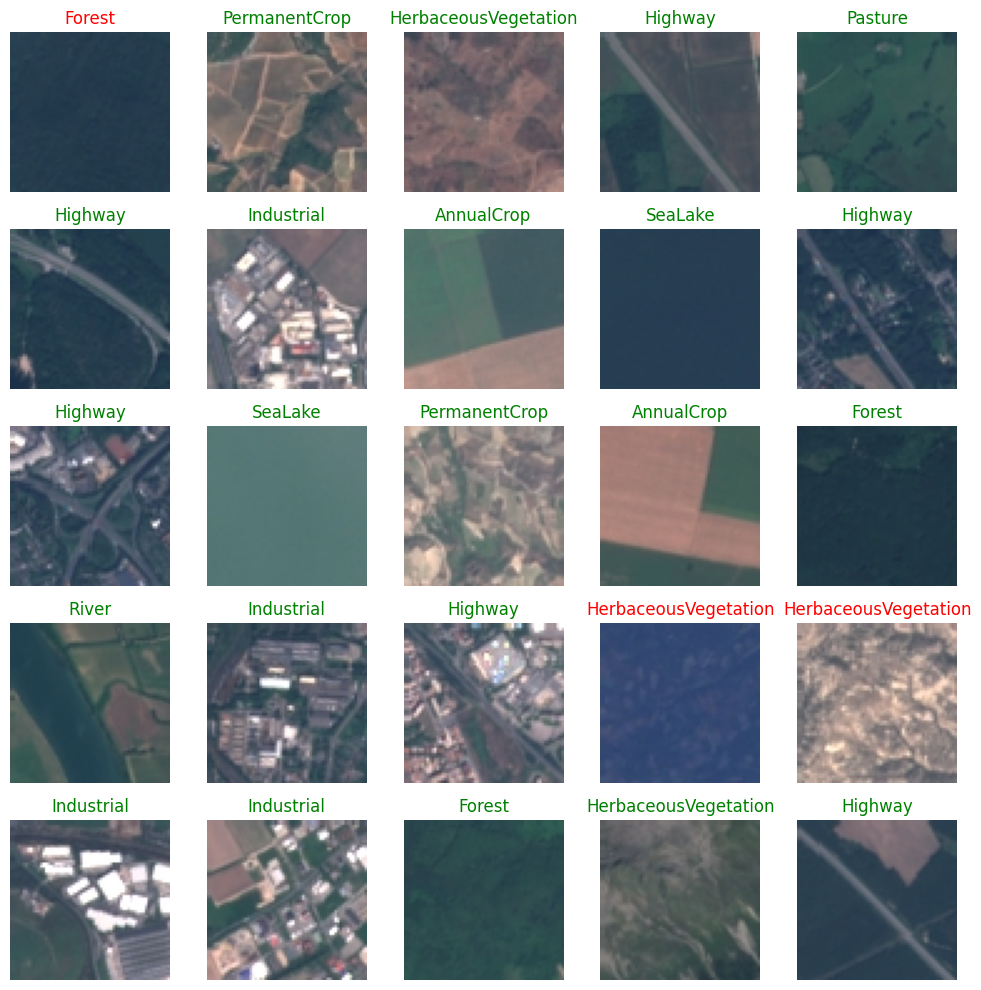

In [30]:
# extract batch from test dataloader

batch = next(iter(ds.test_dataloader(shuffle=True, batch_size=25)))
imgs, labels = batch['image'], batch['label']

# compute predictions

preds = task.predict(batch)
preds = torch.argmax(preds, axis=1)

# visualize predictions

fig = plt.figure(figsize=(10, 10))
for i, (img, label, pred) in enumerate(zip(imgs, labels, preds)):
	ax = plt.subplot(5, 5, i + 1)
	ax.imshow(img.permute(1,2,0))
	gt = ds.classes[label.item()]
	pred = ds.classes[pred.item()]
	ax.set_title(gt, color="green" if gt == pred else 'red')
	ax.axis('off')
plt.tight_layout()
plt.show()